In [1]:
import sys
sys.path.append('../03-code/')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio

from config import PROJECT_ROOT_DIRECTORY, IDENTIFIER_DICT, COLUMNS_DICT

### Visualize Chemical Space

* Chemical space with morphing pathway

In [2]:
# read the fingerprint dataframes and combine them into one dataframe
fingerprint_dataframe = pd.DataFrame()
for i in range(0, 7):
    fingerprint_dataframe_gen = pd.read_csv(
        PROJECT_ROOT_DIRECTORY + '01-rawdata/01-molecular-generation/fingerprints/fingerprints_generation_'+str(i)+'.csv')
    fingerprint_dataframe_gen['generation'] = i
    fingerprint_dataframe = pd.concat([fingerprint_dataframe, fingerprint_dataframe_gen], axis=0, ignore_index=True)

organic_genome_dataframe = pd.read_csv(
    PROJECT_ROOT_DIRECTORY+'02-metadata/06-csv-files/01-organic-genome.csv', index_col='identifier')



In [3]:
fingerprint_dataframe

smiles_canonical  ringcount  linkage_p  \
0                        [NH3+]Cc1ccc(C[NH3+])cc1          1        0.0   
1                         [NH3+]Cc1ccc(C[NH3+])s1          1        0.0   
2                         [NH3+]Cc1csc(C[NH3+])c1          1        0.0   
3             [NH3+]Cc1ccc(-c2ccc(C[NH3+])cc2)cc1          2        1.0   
4              [NH3+]Cc1ccc(-c2csc(C[NH3+])c2)cc1          2        1.0   
...                                           ...        ...        ...   
4887095  Cc1c(F)c(C(C)[NH3+])c(C)c(F)c1C(C)[NH3+]          1        0.0   
4887096  Cc1c(F)c(C(C)[NH3+])c(F)c(C)c1C(C)[NH3+]          1        0.0   
4887097  Cc1c(C)c(C(C)[NH3+])c(F)c(F)c1C(C)[NH3+]          1        0.0   
4887098  Cc1c(C)c(C(C)[NH3+])c(F)c(C)c1C(C)[NH3+]          1        0.0   
4887099  Cc1c(C)c(C(C)[NH3+])c(C)c(C)c1C(C)[NH3+]          1        0.0   

         six_ring_p  primaryamine  linker_length  linker_position  \
0               1.0             2              2              1.0   
1               0.0             2              2              1.0   
2               0.0             2              2              1.0   
3               1.0             2              2              1.0   
4               0.5             2              2              1.0   
...             ...           ...            ...              ...   
4887095         1.0             2              2              1.0   
4887096         1.0             2              2              1.0   
4887097         1.0             2              2              1.0   
4887098         1.0             2              2              1.0   
4887099         1.0             2              2              1.0   

         hetero_nitrogen  fluorination  furan  pyrrole  sidechain_on_linker  \
0                      0             0      0        0                    0   
1                      0             0      0        0                    0   
2                      0             0      0        0                    0   
3                      0             0      0        0                    0   
4                      0             0      0        0                    0   
...                  ...           ...    ...      ...                  ...   
4887095                0             2      0        0                    2   
4887096                0             2      0        0                    2   
4887097                0             2      0        0                    2   
4887098                0             1      0        0                    2   
4887099                0             0      0        0                    2   

         sidechain_on_backbone  generation  
0                            0           0  
1                            0           1  
2                            0           1  
3                            0           1  
4                            0           1  
...                        ...         ...  
4887095                      2           6  
4887096                      2           6  
4887097                      2           6  
4887098                      3           6  
4887099                      4           6  

[4887100 rows x 14 columns]

In [41]:
index_list = fingerprint_dataframe.query('generation<=1').drop(columns=['smiles_canonical','generation']).drop_duplicates().index

In [ ]:
from utils import visualize_smiles_list
smiles_list = fingerprint_dataframe.loc[index_list].smiles_canonical.tolist()
visualize_smiles_list(smiles_list[:50])

In [3]:
existing_dataframe = organic_genome_dataframe.loc[IDENTIFIER_DICT['existing']].reset_index()
existing_fingerprints_dataframe = pd.merge(left=existing_dataframe, right=fingerprint_dataframe, left_on='smiles_canonical',right_on='smiles_canonical')[COLUMNS_DICT['molecular_fingerprint']+['identifier']]
existing_fingerprints_dataframe['exist'] = 'Y'

In [31]:
typeIb_dataframe = organic_genome_dataframe.loc[IDENTIFIER_DICT['typeI_b']].reset_index()
typeIb_dataframe['final'] = 'Ib'
typeIIa_dataframe = organic_genome_dataframe.loc[IDENTIFIER_DICT['typeII_a']].reset_index()
typeIIa_dataframe['final'] = 'IIa'
typeIIb_dataframe = organic_genome_dataframe.loc[IDENTIFIER_DICT['typeII_b']].reset_index()
typeIIb_dataframe['final'] = 'IIb'

# combine the typeIb, typeIIa, and typeIIb dataframes
final_candidate_dataframe = pd.concat([typeIb_dataframe, typeIIa_dataframe, typeIIb_dataframe], axis=0, ignore_index=True)
final_candidate_dataframe = pd.merge(left=final_candidate_dataframe, right=fingerprint_dataframe, left_on='smiles_canonical',right_on='smiles_canonical')[COLUMNS_DICT['molecular_fingerprint']+['identifier', 'final']]

In [6]:
final_candidate_dataframe = organic_genome_dataframe.loc[IDENTIFIER_DICT['typeI_b']+IDENTIFIER_DICT['typeII_a']+IDENTIFIER_DICT['typeII_b']].reset_index()
final_candidate_dataframe = pd.merge(left=final_candidate_dataframe, right=fingerprint_dataframe, left_on='smiles_canonical',right_on='smiles_canonical')[COLUMNS_DICT['molecular_fingerprint']+['identifier']]
final_candidate_dataframe['final'] = 'Y'

### t-SNE

In [ ]:
from sklearn.manifold import TSNE

fingerprint_dataframe_duplicate_removed = fingerprint_dataframe.drop(columns=['generation', 'smiles_canonical'])
fingerprint_dataframe_duplicate_removed = fingerprint_dataframe_duplicate_removed.drop_duplicates()
tsne_components = TSNE(n_components=2, learning_rate='auto',perplexity=40).fit_transform(fingerprint_dataframe_duplicate_removed.values)

tsne_dataframe = pd.DataFrame(data=tsne_components, columns=['tsne-1','tsne-2'], index=fingerprint_dataframe_duplicate_removed.index)
tsne_dataframe = pd.concat([fingerprint_dataframe_duplicate_removed, tsne_dataframe, fingerprint_dataframe.loc[fingerprint_dataframe_duplicate_removed.index, 'generation']],axis=1)

In [71]:
tsne_dataframe.to_csv(PROJECT_ROOT_DIRECTORY+'01-rawdata/18-chemical-space/tsne-perplexity-40-dataframe.csv',index=False)

### Visualize tsne representation

In [91]:
# best parameter: 40 (30, 40)
tsne_dataframe = pd.read_csv(PROJECT_ROOT_DIRECTORY+'01-rawdata/18-chemical-space/tsne-perplexity-40-dataframe.csv')

In [66]:
existing_fingerprints_dataframe

ringcount  linkage_p  six_ring_p  primaryamine  linker_length  \
0           2        0.0         0.0             2              2   
1           1        0.0         0.0             2              2   
2           1        0.0         1.0             1              1   
3           1        0.0         1.0             2              2   
4           1        0.0         1.0             1              1   
5           1        0.0         1.0             2              0   
6           1        0.0         1.0             2              0   
7           1        0.0         1.0             2              2   
8           2        1.0         0.0             2              2   
9           2        1.0         1.0             2              2   
10          1        0.0         1.0             1              2   
11          1        0.0         1.0             2              4   
12          2        0.0         1.0             2              0   
13          3        1.0         0.0             2              4   
14          1        0.0         0.0             1              2   
15          2        1.0         1.0             2              2   
16          2        1.0         0.5             2              2   
17          2        1.0         0.0             2              4   
18          4        1.0         0.0             2              4   
19          1        0.0         1.0             1              1   
20          1        0.0         1.0             2              2   

    linker_position  hetero_nitrogen  fluorination  furan  pyrrole  \
0          1.000000                0             0      0        0   
1          1.000000                0             0      0        0   
2          0.666667                0             0      0        0   
3          1.000000                0             0      0        0   
4          1.000000                0             0      0        0   
5          1.000000                0             0      0        0   
6          0.666667                0             0      0        0   
7          1.000000                0             4      0        0   
8          1.000000                0             0      0        0   
9          1.000000                0             0      0        0   
10         0.666667                0             0      0        0   
11         1.000000                0             0      0        0   
12         0.600000                0             0      0        0   
13         1.000000                0             0      0        0   
14         0.500000                0             0      0        1   
15         1.000000                0             1      0        0   
16         1.000000                0             1      0        0   
17         1.000000                0             0      0        0   
18         1.000000                0             0      0        0   
19         0.666667                0             0      0        0   
20         1.000000                0             0      0        0   

    sidechain_on_linker  sidechain_on_backbone  identifier exist  
0                     0                      0           1     Y  
1                     0                      0           4     Y  
2                     0                      0          11     Y  
3                     0                      0          26     Y  
4                     0                      0          37     Y  
5                     0                      0          56     Y  
6                     0                      0          59     Y  
7                     0                      0          60     Y  
8                     0                      0         100     Y  
9                     0                      0         105     Y  
10                    0                      0         163     Y  
11                    0                      0         175     Y  
12                    0                      0         188     Y  
13    

In [92]:
tsne_dataframe = pd.merge(left=tsne_dataframe, right=existing_fingerprints_dataframe, how='left',on=COLUMNS_DICT['molecular_fingerprint'])

In [84]:
tsne_dataframe

ringcount  linkage_p  six_ring_p  primaryamine  linker_length  \
0              1        0.0         1.0             2              2   
1              1        0.0         0.0             2              2   
2              2        1.0         1.0             2              2   
3              2        1.0         0.5             2              2   
4              2        0.0         1.0             2              2   
...          ...        ...         ...           ...            ...   
21340          1        0.0         1.0             2              2   
21341          1        0.0         1.0             2              2   
21342          1        0.0         1.0             2              2   
21343          1        0.0         1.0             2              2   
21344          1        0.0         1.0             2              2   

       linker_position  hetero_nitrogen  fluorination  furan  pyrrole  \
0                  1.0                0             0      0        0   
1                  1.0                0             0      0        0   
2                  1.0                0             0      0        0   
3                  1.0                0             0      0        0   
4                  1.0                0             0      0        0   
...                ...              ...           ...    ...      ...   
21340              1.0                0             4      0        0   
21341              1.0                0             3      0        0   
21342              1.0                0             2      0        0   
21343              1.0                0             1      0        0   
21344              1.0                0             0      0        0   

       sidechain_on_linker  sidechain_on_backbone     tsne-1     tsne-2  \
0                        0                      0 -81.794470  -5.616562   
1                        0                      0 -64.729990  -5.366804   
2                        0                      0  -8.335023 -14.242904   
3                        0                      0  -8.511146 -13.778076   
4                        0                      0 -18.656912 -12.024436   
...                    ...                    ...        ...        ...   
21340                    2                      0 -80.825140  -1.447335   
21341                    2                      1 -80.000160  -1.273936   
21342                    2                      2 -77.782090  -2.373300   
21343                    2                      3 -75.020700  -4.761385   
21344                    2                      4 -74.361940  -5.301897   

       generation  identifier final exist  
0               0         NaN   NaN   NaN  
1               1         NaN   NaN   NaN  
2               1         NaN   NaN   NaN  
3               1         NaN   NaN   NaN  
4               1         NaN   NaN   NaN  
...           ...         ...   ...   ...  
21340           6         NaN   NaN   NaN  
21341           6         NaN   NaN   NaN  
21342           6         NaN   NaN   NaN  
21343           6         NaN   NaN   NaN  
21344           6         NaN   NaN   NaN  

[21345 rows x 18 columns]

In [93]:
tsne_dataframe = pd.merge(left=tsne_dataframe, right=final_candidate_dataframe, how='left',on=COLUMNS_DICT['molecular_fingerprint'])

In [88]:
tsne_dataframe['exist'].value_counts()

exist
Y    3
Name: count, dtype: int64

In [29]:
tsne_dataframe.loc[21306,'generation'] = 7
tsne_dataframe

ringcount  linkage_p  six_ring_p  primaryamine  linker_length  \
0            1.0        0.0         1.0           2.0            2.0   
1            1.0        0.0         1.0           2.0            2.0   
2            1.0        0.0         0.0           2.0            2.0   
3            2.0        1.0         1.0           2.0            2.0   
4            2.0        1.0         0.5           2.0            2.0   
...          ...        ...         ...           ...            ...   
21302        1.0        0.0         1.0           2.0            2.0   
21303        1.0        0.0         1.0           2.0            2.0   
21304        1.0        0.0         1.0           2.0            2.0   
21305        1.0        0.0         1.0           2.0            2.0   
21306        NaN        NaN         NaN           NaN            NaN   

       linker_position  hetero_nitrogen  fluorination  furan  pyrrole  \
0                  1.0              0.0           0.0    0.0      0.0   
1                  1.0              0.0           0.0    0.0      0.0   
2                  1.0              0.0           0.0    0.0      0.0   
3                  1.0              0.0           0.0    0.0      0.0   
4                  1.0              0.0           0.0    0.0      0.0   
...                ...              ...           ...    ...      ...   
21302              1.0              0.0           3.0    0.0      0.0   
21303              1.0              0.0           2.0    0.0      0.0   
21304              1.0              0.0           1.0    0.0      0.0   
21305              1.0              0.0           0.0    0.0      0.0   
21306              NaN              NaN           NaN    NaN      NaN   

       sidechain_on_linker  sidechain_on_backbone     tsne-1     tsne-2  \
0                      0.0                    0.0 -81.794470  -5.616562   
1                      0.0                    0.0 -81.794470  -5.616562   
2                      0.0                    0.0 -64.729990  -5.366804   
3                      0.0                    0.0  -8.335023 -14.242904   
4                      0.0                    0.0  -8.511146 -13.778076   
...                    ...                    ...        ...        ...   
21302                  2.0                    1.0 -80.000160  -1.273936   
21303                  2.0                    2.0 -77.782090  -2.373300   
21304                  2.0                    3.0 -75.020700  -4.761385   
21305                  2.0                    4.0 -74.361940  -5.301897   
21306                  NaN                    NaN        NaN        NaN   

       generation  identifier exist  
0             0.0        26.0     Y  
1             0.0       380.0     Y  
2             1.0         4.0     Y  
3             1.0       105.0     Y  
4             1.0         NaN   NaN  
...           ...         ...   ...  
21302         6.0         NaN   NaN  
21303         6.0         NaN   NaN  
21304         6.0         NaN   NaN  
21305         6.0         NaN   NaN  
21306         7.0         NaN   NaN  

[21307 rows x 17 columns]

In [52]:
tsne_dataframe.query('final=="IIa"')

ringcount  linkage_p  six_ring_p  primaryamine  linker_length  \
108           3        1.0         0.0             2              2   
564           4        1.0         0.0             2              2   
603           2        1.0         0.0             2              4   
1635          3        0.0         1.0             2              4   
2244          5        1.0         0.0             2              2   
2283          3        1.0         0.0             2              4   
5827          4        0.0         1.0             2              0   
7443          4        1.0         0.0             2              4   
7450          4        1.0         0.0             2              0   
8152          2        1.0         0.0             2              6   

      linker_position  hetero_nitrogen  fluorination  furan  pyrrole  \
108               1.0                0             0      0        0   
564               1.0                0             0      0        0   
603               1.0                0             0      0        0   
1635              1.0                0             0      0        0   
2244              1.0                0             0      0        0   
2283              1.0                0             0      0        0   
5827              1.0                0             0      0        0   
7443              1.0                0             0      0        0   
7450              1.0                0             0      0        0   
8152              1.0                0             0      0        0   

      sidechain_on_linker  sidechain_on_backbone      tsne-1      tsne-2  \
108                     0                      0   42.700620  -19.616450   
564                     0                      0   97.983665  -12.808087   
603                     0                      0  -53.406494   59.436295   
1635                    0                      0  -44.932953   84.194435   
2244                    0                      0  116.446020   -5.819492   
2283                    0                      0  -44.631840   81.708180   
5827                    0                      0   25.235062 -101.747880   
7443                    0                      0   -1.662916  101.263280   
7450                    0                      0   22.658327 -100.973330   
8152                    0                      0  -77.391490   59.023045   

     generation identifier_x exist  identifier_y final  
108           3          nan   nan         101.0   IIa  
564           4          nan   nan         102.0   IIa  
603           4        205.0     Y         205.0   IIa  
1635          4          nan   nan       27437.0   IIa  
2244          5          nan   nan         239.0   IIa  
2283          5        189.0     Y         189.0   IIa  
5827          5          nan   nan         184.0   IIa  
7443          6        206.0     Y         206.0   IIa  
7450          6          nan   nan       36228.0   IIa  
8152          6          nan   nan       35575.0   IIa

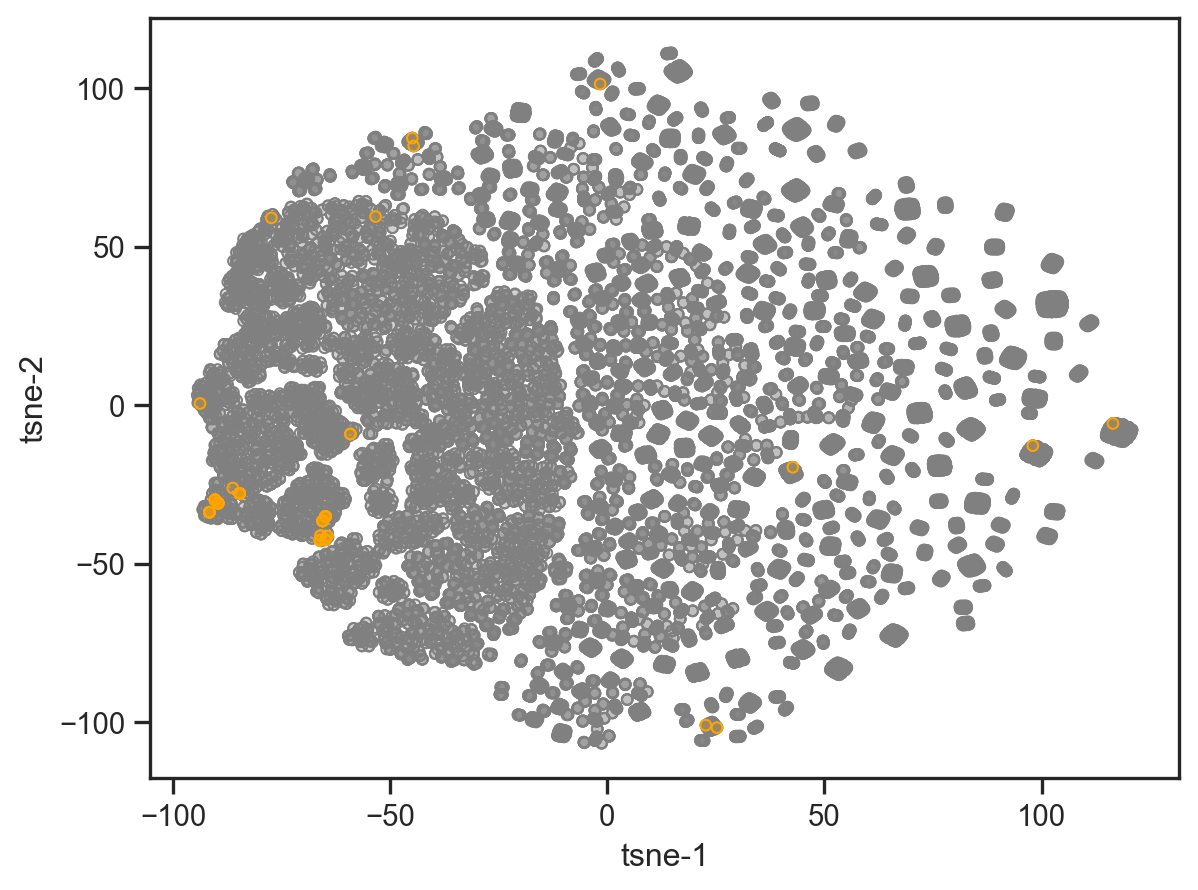

In [ ]:
import seaborn.objects as so
from seaborn import axes_style

#fig, ax = plt.subplots(figsize=(10,10))
(
        so.Plot(data=tsne_dataframe, x='tsne-1', y='tsne-2',)
        .add(so.Dot(color='grey'))
        .add(so.Dots(color='orange'), data=tsne_dataframe.query("final=='Y'"))
        .theme(axes_style("ticks"))
    )

In [87]:
tsne_dataframe

ringcount  linkage_p  six_ring_p  primaryamine  linker_length  \
0              1        0.0         1.0             2              2   
1              1        0.0         0.0             2              2   
2              2        1.0         1.0             2              2   
3              2        1.0         0.5             2              2   
4              2        0.0         1.0             2              2   
...          ...        ...         ...           ...            ...   
21340          1        0.0         1.0             2              2   
21341          1        0.0         1.0             2              2   
21342          1        0.0         1.0             2              2   
21343          1        0.0         1.0             2              2   
21344          1        0.0         1.0             2              2   

       linker_position  hetero_nitrogen  fluorination  furan  pyrrole  \
0                  1.0                0             0      0        0   
1                  1.0                0             0      0        0   
2                  1.0                0             0      0        0   
3                  1.0                0             0      0        0   
4                  1.0                0             0      0        0   
...                ...              ...           ...    ...      ...   
21340              1.0                0             4      0        0   
21341              1.0                0             3      0        0   
21342              1.0                0             2      0        0   
21343              1.0                0             1      0        0   
21344              1.0                0             0      0        0   

       sidechain_on_linker  sidechain_on_backbone     tsne-1     tsne-2  \
0                        0                      0 -81.794470  -5.616562   
1                        0                      0 -64.729990  -5.366804   
2                        0                      0  -8.335023 -14.242904   
3                        0                      0  -8.511146 -13.778076   
4                        0                      0 -18.656912 -12.024436   
...                    ...                    ...        ...        ...   
21340                    2                      0 -80.825140  -1.447335   
21341                    2                      1 -80.000160  -1.273936   
21342                    2                      2 -77.782090  -2.373300   
21343                    2                      3 -75.020700  -4.761385   
21344                    2                      4 -74.361940  -5.301897   

       generation  identifier final exist  
0               0         NaN   NaN   NaN  
1               1         NaN   NaN   NaN  
2               1         NaN   NaN   NaN  
3               1         NaN   NaN   NaN  
4               1         NaN   NaN   NaN  
...           ...         ...   ...   ...  
21340           6         NaN   NaN   NaN  
21341           6         NaN   NaN   NaN  
21342           6         NaN   NaN   NaN  
21343           6         NaN   NaN   NaN  
21344           6         NaN   NaN   NaN  

[21345 rows x 18 columns]

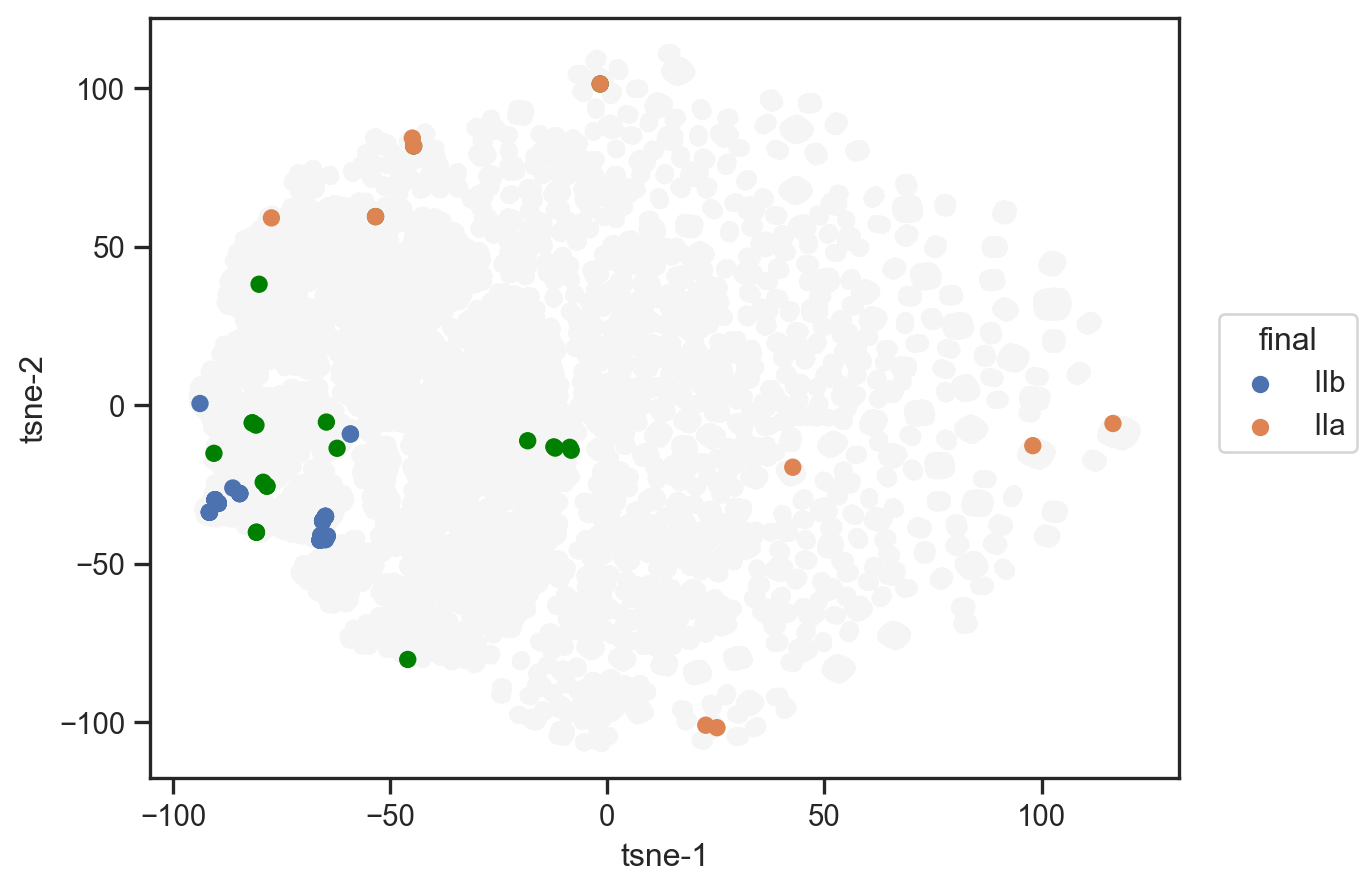

In [95]:
(
        so.Plot(data=tsne_dataframe, x='tsne-1', y='tsne-2',)
        .add(so.Dot(color='whitesmoke'))
        .add(so.Dot(color='green'), data=tsne_dataframe.query("exist=='Y'"))
        .add(so.Dot(), data=tsne_dataframe,color='final')
        .theme(axes_style("ticks"))
        #save figure
        .save('../rawfigures/tsne-plot.svg')
    )

In [79]:
tsne_dataframe

ringcount  linkage_p  six_ring_p  primaryamine  linker_length  \
0              1        0.0         1.0             2              2   
1              1        0.0         0.0             2              2   
2              2        1.0         1.0             2              2   
3              2        1.0         0.5             2              2   
4              2        0.0         1.0             2              2   
...          ...        ...         ...           ...            ...   
21340          1        0.0         1.0             2              2   
21341          1        0.0         1.0             2              2   
21342          1        0.0         1.0             2              2   
21343          1        0.0         1.0             2              2   
21344          1        0.0         1.0             2              2   

       linker_position  hetero_nitrogen  fluorination  furan  pyrrole  \
0                  1.0                0             0      0        0   
1                  1.0                0             0      0        0   
2                  1.0                0             0      0        0   
3                  1.0                0             0      0        0   
4                  1.0                0             0      0        0   
...                ...              ...           ...    ...      ...   
21340              1.0                0             4      0        0   
21341              1.0                0             3      0        0   
21342              1.0                0             2      0        0   
21343              1.0                0             1      0        0   
21344              1.0                0             0      0        0   

       sidechain_on_linker  sidechain_on_backbone     tsne-1     tsne-2  \
0                        0                      0 -81.794470  -5.616562   
1                        0                      0 -64.729990  -5.366804   
2                        0                      0  -8.335023 -14.242904   
3                        0                      0  -8.511146 -13.778076   
4                        0                      0 -18.656912 -12.024436   
...                    ...                    ...        ...        ...   
21340                    2                      0 -80.825140  -1.447335   
21341                    2                      1 -80.000160  -1.273936   
21342                    2                      2 -77.782090  -2.373300   
21343                    2                      3 -75.020700  -4.761385   
21344                    2                      4 -74.361940  -5.301897   

       generation  identifier final  
0               0         NaN   NaN  
1               1         NaN   NaN  
2               1         NaN   NaN  
3               1         NaN   NaN  
4               1         NaN   NaN  
...           ...         ...   ...  
21340           6         NaN   NaN  
21341           6         NaN   NaN  
21342           6         NaN   NaN  
21343           6         NaN   NaN  
21344           6         NaN   NaN  

[21345 rows x 17 columns]

In [81]:
import plotly.express as px

# Make sure relevant columns are of string type
#tsne_dataframe['identifier_x'] = tsne_dataframe['identifier_x'].astype(str)
#tsne_dataframe['generation'] = tsne_dataframe['generation'].astype(str)
#tsne_dataframe['exist'] = tsne_dataframe['exist'].astype(str)

fig = px.scatter(
    tsne_dataframe,
    x='tsne-1',
    y='tsne-2',
    color='final',
    hover_data=['identifier', 'generation']
)

fig.show()


/Users/yongxinlyu/opt/anaconda3/envs/dj-perovskite-env/lib/python3.12/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



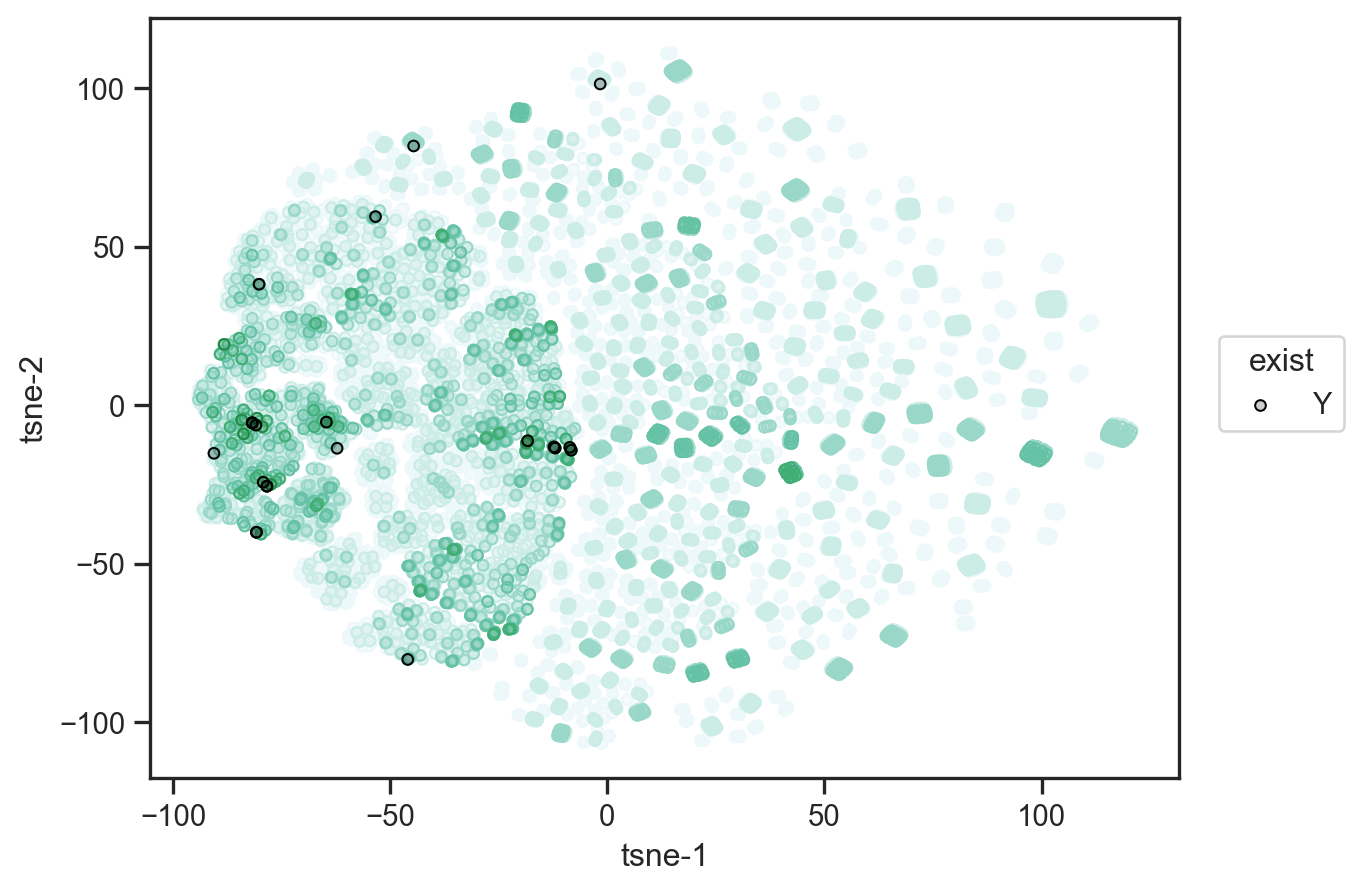

In [76]:
(
        so.Plot(data=tsne_dataframe, x='tsne-1', y='tsne-2',)
        .add(so.Dots(color='#edf8fb'), data=tsne_dataframe.query('generation==6'))
        .add(so.Dots(color='#ccece6'), data=tsne_dataframe.query('generation==5'))
        .add(so.Dots(color='#99d8c9'), data=tsne_dataframe.query('generation==4'))
        .add(so.Dots(color='#66c2a4'), data=tsne_dataframe.query('generation==3'))
        .add(so.Dots(color='#41ae76'), data=tsne_dataframe.query('generation==2'))
        .add(so.Dots(color='#238b45'), data=tsne_dataframe.query('generation==1'))
        .add(so.Dots(color='#005824'), data=tsne_dataframe.query('generation==0'))
        .add(so.Dots(color='black'), color='exist')
        .theme(axes_style("ticks"))
        .scale(color='flare')
        #.on(ax)
        #.plot()
    )

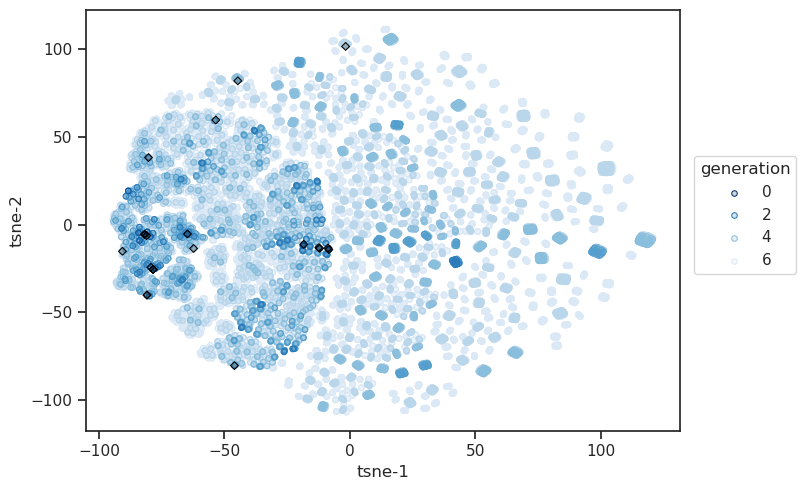

In [30]:
fig = plt.figure(figsize=(7, 5))

(
        so.Plot(data=tsne_dataframe.sort_values(by='generation',ascending=False), x='tsne-1', y='tsne-2',color='generation')
        .add(so.Dots())
        .add(so.Dots(marker='D',color='black'), data=tsne_dataframe.query('exist=="Y"'),legend=False)
        .theme(axes_style("ticks"))
        .scale(color="Blues_r") #Blues_r,light:g_r
        .on(fig)
        .plot()
)
fig.tight_layout()
fig.savefig('../rawfigures/chemical-space.svg')

[]

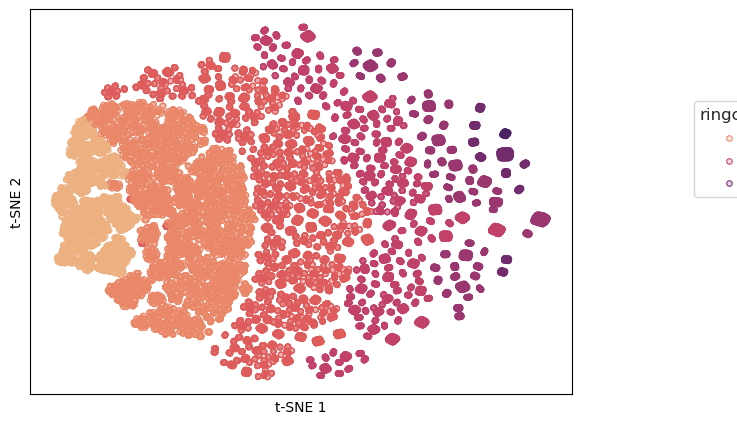

In [4]:
import seaborn.objects as so
from seaborn import axes_style
fig, ax = plt.subplots(figsize=(7, 5))
(
        so.Plot(data=tsne_dataframe.reset_index(), x='tsne-1', y='tsne-2', color='ringcount')
        .add(so.Dots())
        .theme(axes_style("ticks"))
        .scale(color='flare')
        .on(ax)
        .plot()
    )

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_xticks([])
ax.set_yticks([])
#fig.tight_layout()
#fig.savefig('../rawfigures/chemical-space-ringcount.svg')


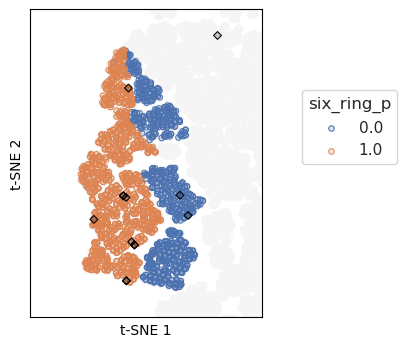

In [ ]:
fig, ax = plt.subplots(figsize=(3, 4))
(
        so.Plot(data=tsne_dataframe.reset_index(), x='tsne-1', y='tsne-2')
        .add(so.Dot(color='whitesmoke'))
        .add(so.Dots(),data=tsne_dataframe.reset_index().query("ringcount == 1"), color='six_ring_p')
        .add(so.Dots(marker='D',color='black'), data=tsne_dataframe.query('exist=="Y"'),legend=False)
        .theme(axes_style("ticks"))
        .scale(color='deep')
        .limit(x=(-110, -40), y=(-55, 70))
        .on(ax)
        .plot()
    )

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_xticks([])
ax.set_yticks([])
#fig.savefig('../rawfigures/chemical-space-ringcount-1.svg')

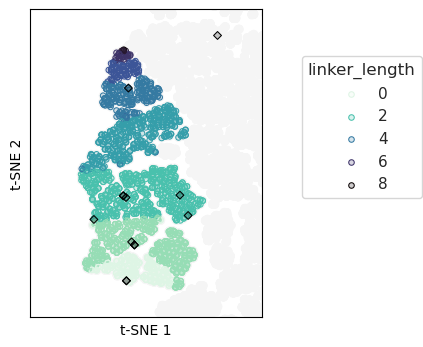

In [54]:
fig, ax = plt.subplots(figsize=(3, 4))
(
        so.Plot(data=tsne_dataframe.reset_index(), x='tsne-1', y='tsne-2')
        .add(so.Dot(color='whitesmoke'))
        .add(so.Dots(),data=tsne_dataframe.reset_index().query("ringcount == 1"), color='linker_length')
        .add(so.Dots(marker='D',color='black'), data=tsne_dataframe.query('exist=="Y"'),legend=False)
        .theme(axes_style("ticks"))
        .scale(color='mako_r')
        .limit(x=(-110, -40), y=(-55, 70))
        .on(ax)
        .plot()
    )

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_xticks([])
ax.set_yticks([])
fig.savefig('../rawfigures/chemical-space-ringcount-1.svg')

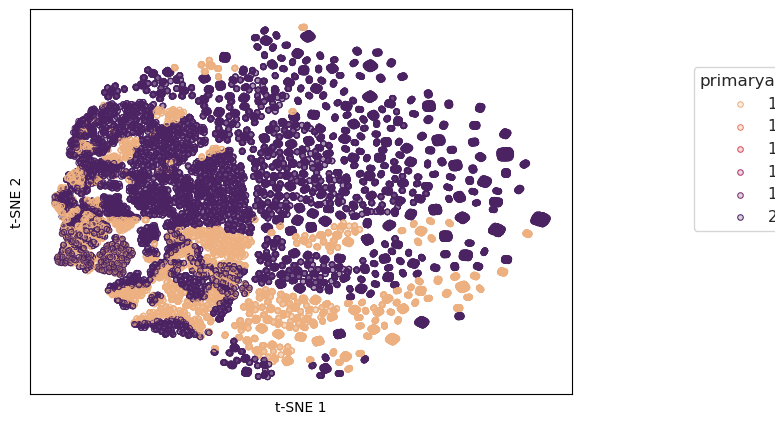

In [20]:
import seaborn.objects as so
from seaborn import axes_style
fig, ax = plt.subplots(figsize=(7, 5))
(
        so.Plot(data=tsne_dataframe.reset_index(), x='tsne-1', y='tsne-2', color='primaryamine')
        .add(so.Dots())
        .theme(axes_style("ticks"))
        .scale(color='flare')
        .on(ax)
        .plot()
    )

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_xticks([])
ax.set_yticks([])
#fig.tight_layout()
fig.savefig('../rawfigures/chemical-space-primaryamine.svg')

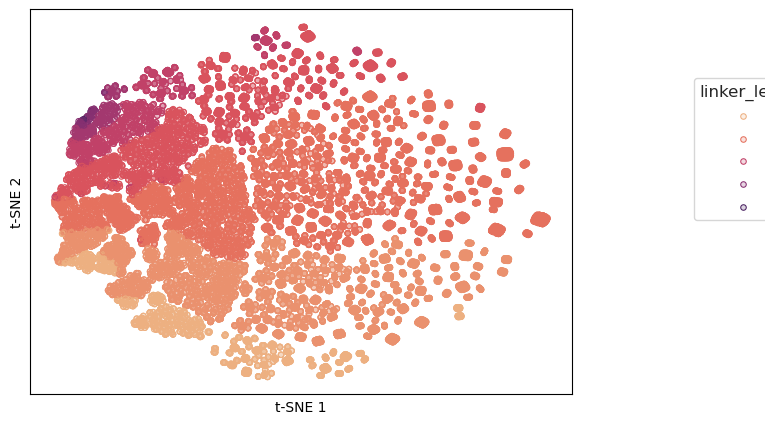

In [21]:
fig, ax = plt.subplots(figsize=(7, 5))
(
        so.Plot(data=tsne_dataframe.reset_index(), x='tsne-1', y='tsne-2', color='linker_length')
        .add(so.Dots())
        .theme(axes_style("ticks"))
        .scale(color='flare')
        .on(ax)
        .plot()
    )

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_xticks([])
ax.set_yticks([])
#fig.tight_layout()
fig.savefig('../rawfigures/chemical-space-linkerlength.svg')

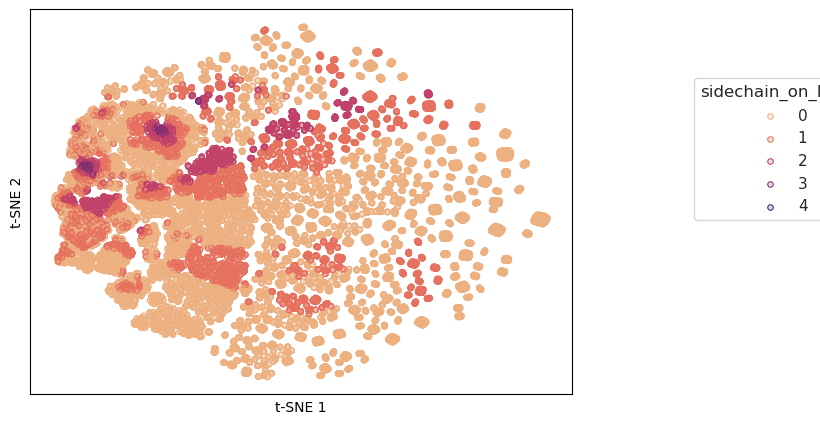

In [32]:
fig, ax = plt.subplots(figsize=(7, 5))
(
        so.Plot(data=tsne_dataframe.reset_index(), x='tsne-1', y='tsne-2', color='sidechain_on_linker')
        .add(so.Dots())
        .theme(axes_style("ticks"))
        .scale(color='flare')
        .on(ax)
        .plot()
    )

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_xticks([])
ax.set_yticks([])
#fig.tight_layout()
fig.savefig('../rawfigures/chemical-space-sidechain_on_linker.svg')

### PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(fingerprint_dataframe_duplicate_removed.values)
pca_dataframe = pd.DataFrame(data=pca_components, columns=['d1','d2'],index=fingerprint_dataframe_duplicate_removed.index)

pca_dataframe = pd.concat([fingerprint_dataframe_duplicate_removed, pca_dataframe, fingerprint_dataframe.loc[fingerprint_dataframe_duplicate_removed.index, 'generation']],axis=1)

In [151]:
pca_dataframe.to_csv(PROJECT_ROOT_DIRECTORY+'01-rawdata/18-chemical-space/pca-dataframe.csv',index=False)

In [152]:
pca_dataframe = pd.read_csv(PROJECT_ROOT_DIRECTORY+'01-rawdata/18-chemical-space/pca-dataframe.csv')

In [ ]:
pca_dataframe = pd.merge(left=pca_dataframe, right=existing_fingerprints_dataframe, how='left',on=COLUMNS_DICT['molecular_fingerprint'])


In [158]:
pca_dataframe.loc[21306,'generation'] = 7

In [30]:
# visualize pca_dataframe using plotly
import plotly.express as px

fig = px.scatter(pca_dataframe, x='d1', y='d2', color='generation', hover_data=['generation'])
fig

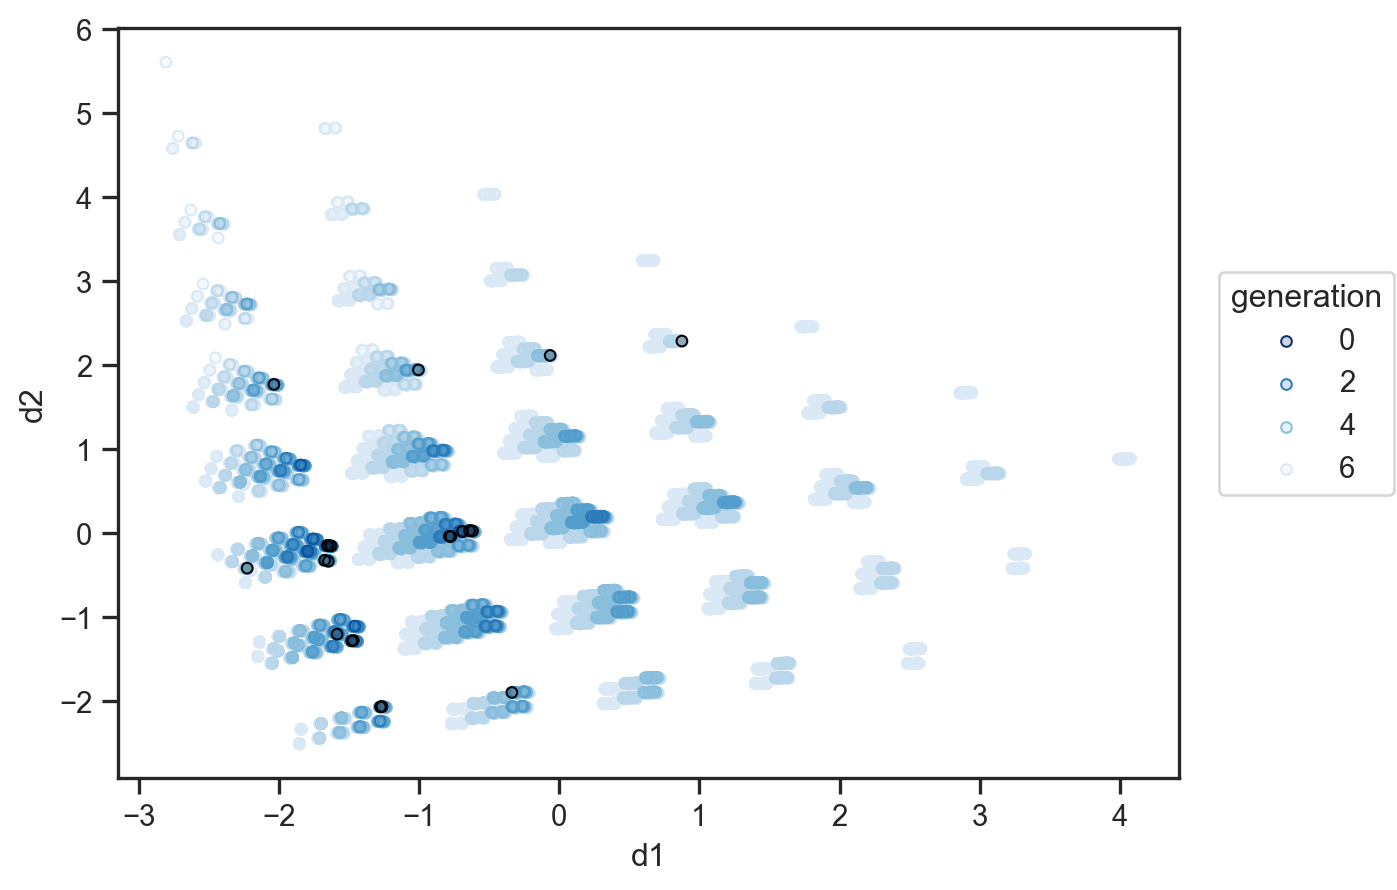

In [159]:
import seaborn.objects as so
from seaborn import axes_style

(
        so.Plot(data=pca_dataframe.sort_values(by='generation',ascending=False), x='d1', y='d2', color='generation')
        .add(so.Dots())
        .add(so.Dots(color='black'),data=pca_dataframe.query('exist == "Y"'),legend=False)
        .theme(axes_style("ticks"))
        .scale(color='Blues_r')
    )

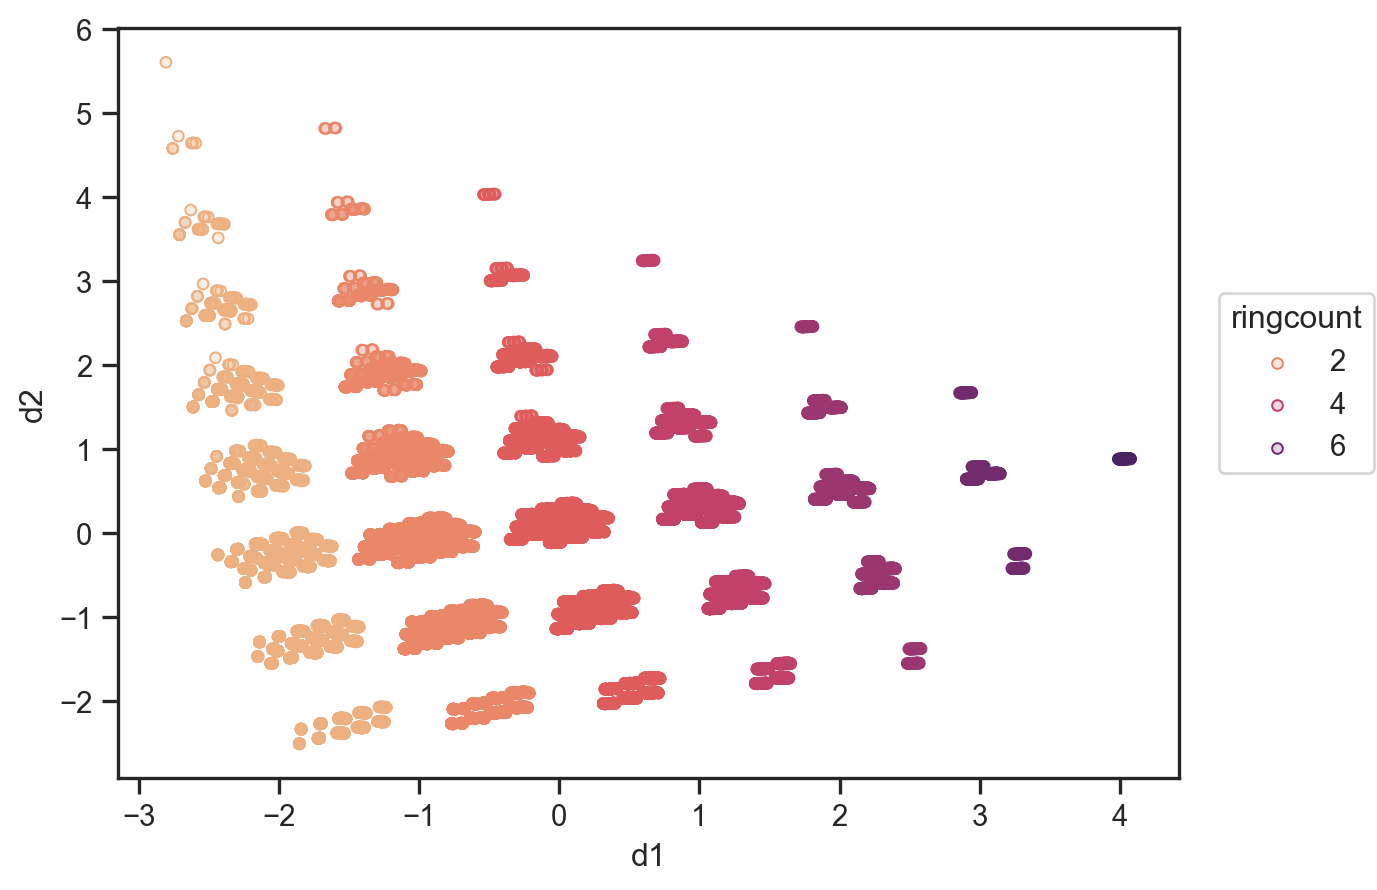

In [160]:
(
        so.Plot(data=pca_dataframe.sort_values(by='generation',ascending=False), x='d1', y='d2', color='ringcount')
        .add(so.Dots())
        .theme(axes_style("ticks"))
        .scale(color='flare')
    )

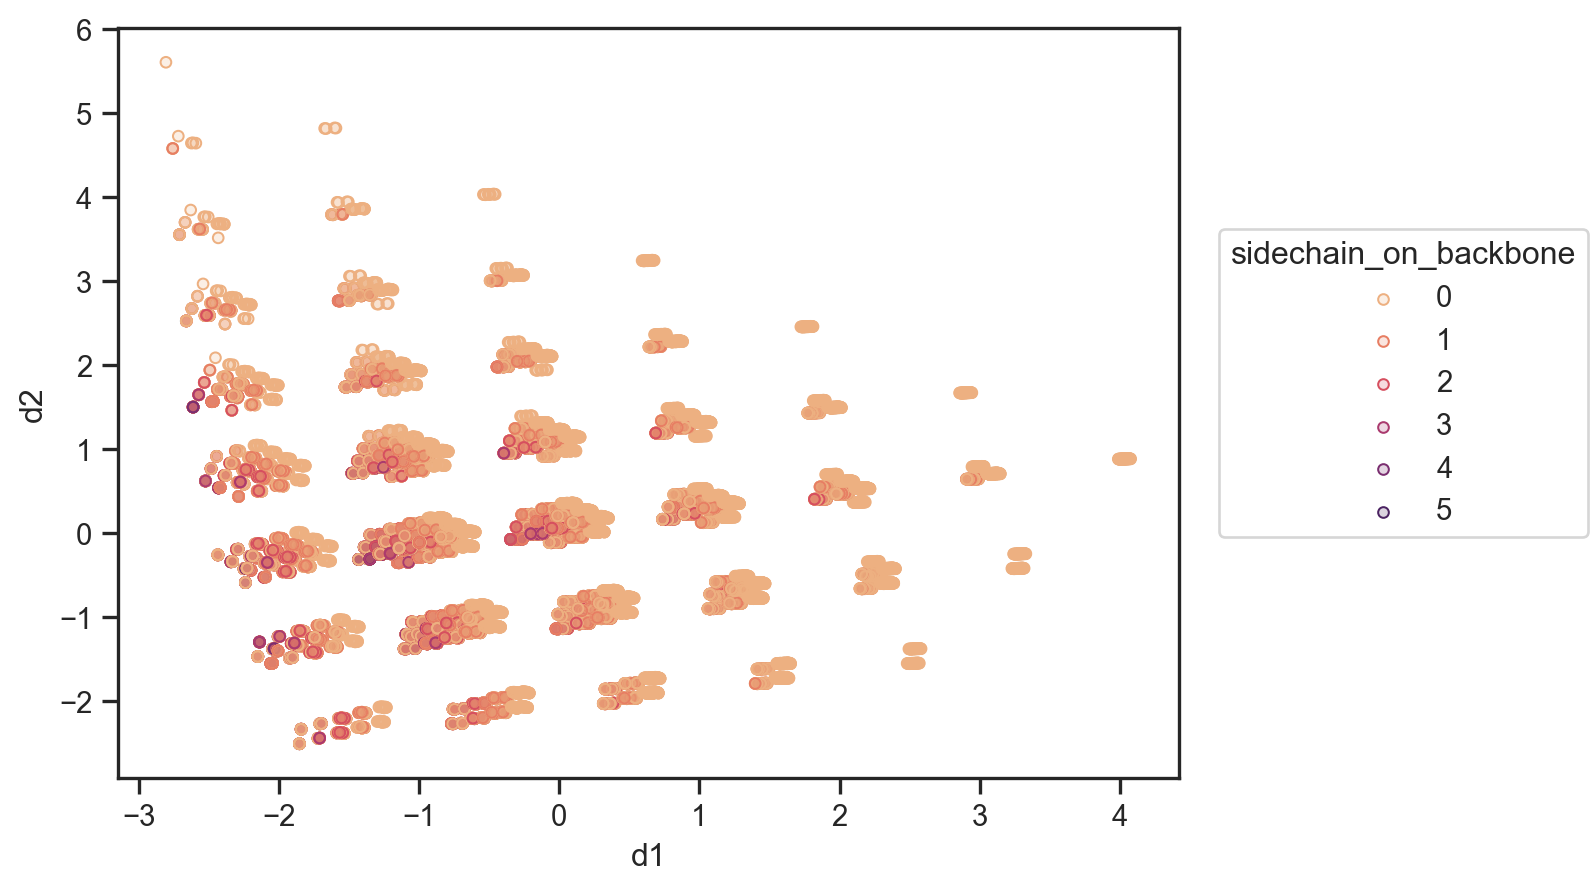

In [171]:
(
        so.Plot(data=pca_dataframe.sort_values(by='generation',ascending=False), x='d1', y='d2', color='sidechain_on_backbone')
        .add(so.Dots())
        .theme(axes_style("ticks"))
        .scale(color='flare')
    )